In [1]:
import pm4py as pm
import numpy as np
import matplotlib.pyplot as plt
import os
from src.visualizer import Visualizer
from src.utils import add_unique_start_end

# Since ProM exports the place information as HTML, you can convert it here to JSON
# Define the old and new file names
old_file_name = "place_files/orderT0.html"
new_file_name = "place_files/orderT0.json"

if os.path.exists(old_file_name):
    # Rename the file
    os.rename(old_file_name, new_file_name)
    print(f"Renamed '{old_file_name}' to '{new_file_name}'")

# Configuration:
PLACE_FILE = "place_files/orderT0.json"
MAX_N_MODELS = 3
# The event log file is only needed for the evaluation (which is optional)
LOG_FILE = "evlog/sample_eventlog_2.xes"
LOG_HAS_START_END = False # Does the event log already have unique start and end activities as the eST-Miner
UNIQUE_START = '▷'
UNIQUE_END = '☐'

In [2]:
VIS = Visualizer(PLACE_FILE)
print("Applying Model Selection...")
VIS.apply_model_selection(MAX_N_MODELS)
print(f'Number of Places: {len(VIS.grouper.total_place_list)}')
print(f'Number of Groups: {len(VIS.grouper.unique_sorted_place_vec_list)}')
print(f'Number of Sels: {len(VIS.model_selection.selections)}')

Model Splitting took 0.04 seconds...
Applying Model Selection...
Model Selection took 0.00 seconds...
Creating Petri nets...


Number of Places: 4329
Number of Groups: 14
Number of Sels: 5


In [3]:
# Reload cell on slider change (There is a bug when automating it)!
VIS.update_selection()
VIS.get_slider_output()
VIS.get_models_output()

Output()

Output()

## Evaluation

In [ ]:
### Run to evaluate the provided configuration ###

# Get the corresponding event log for the row of place files
evlog = pm.read_xes(LOG_FILE)
# Add unique start and end activities
evlog = add_unique_start_end(evlog, UNIQUE_START, UNIQUE_END)

selections_to_eval = VIS.model_selection.selections
freq_values = [VIS.grouper.variant_data_raw[variant]["freq"] for variant in VIS.grouper.variant_data_raw]
total_traces = sum(freq_values)

eval_info = {}
# Extract the file name
eval_info['name'] = os.path.basename(PLACE_FILE).replace(".json", "")
eval_info['fitness'] = np.zeros(len(selections_to_eval), dtype=float)
eval_info['precision'] = np.zeros(len(selections_to_eval), dtype=float)
eval_info['sel_scores'] = np.array([sel[0] for sel in VIS.model_selection.selection_scores])
eval_info['selected_idx'] = VIS.model_selection.selected_idx
print(f"Evaluating {eval_info['name']} with {len(selections_to_eval)} selections!")
for j, sel in enumerate(selections_to_eval):
    # Calculate the fitness for each selection
    eval_info['fitness'][j] = sum(VIS.grouper.variant_data_raw[str(i)]["freq"] * max([vec[i] for vec in sel]) for i in range(len(sel[0]))) / total_traces
    VIS.set_interesting_groups(sel)
    VIS.merge_models_in_list()
    net, im, fm = VIS.model_list[0]
    eval_info['precision'][j] = pm.precision_alignments(evlog, net, im, fm)
eval_info

parsing log, completed traces ::   0%|          | 0/12666 [00:00<?, ?it/s]

Evaluating orderT0 with 5 selections!


computing precision with alignments, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

computing precision with alignments, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

{'name': 'orderT0',
 'fitness': array([0.87565135, 0.87857256, 1.        , 1.        , 1.        ]),
 'precision': array([0.93990029, 0.94606503, 0.92546245, 0.92546245, 0.8425518 ]),
 'sel_scores': array([0.6    , 0.75135, 0.81821, 0.58779, 0.17226]),
 'selected_idx': 2}

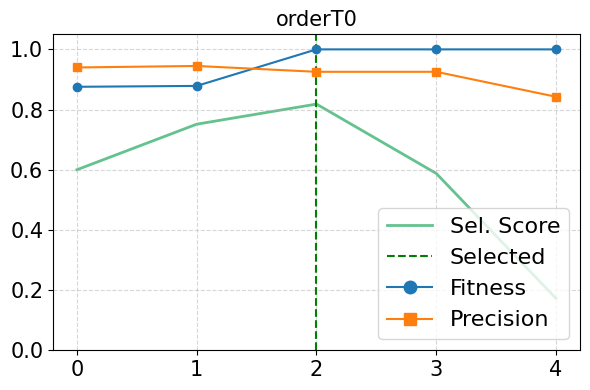

In [ ]:
### Run to generate the fitness/precision analysis plot for the evaluation ###
fig, ax = plt.subplots(figsize=(6, 4))

merge_levels = np.arange(len(eval_info['fitness']))

ax.plot(merge_levels, eval_info['sel_scores'], color='mediumseagreen', alpha=0.8, linewidth=2, label='Sel. Score', zorder=0)

selected_idx = eval_info.get('selected_idx', None)
if selected_idx is not None:
    ax.axvline(selected_idx, color='green', linestyle='--', linewidth=1.5, label='Selected')

ax.plot(merge_levels, eval_info['fitness'], marker='o', label='Fitness', zorder=2)
ax.plot(merge_levels, eval_info['precision'], marker='s', label='Precision', zorder=2)
ax.set_title(f"{eval_info.get('name', 'Plot')}", fontsize=15)

ax.set_xticks(merge_levels)
if len(merge_levels) > 20:
    labels = [str(x) if x % 2 == 0 else '' for x in merge_levels]
    ax.set_xticklabels(labels, fontsize=15)
else:
    ax.set_xticklabels(merge_levels, fontsize=15)

ax.tick_params(axis='y', labelsize=15)
ax.set_ylim(0, 1.05)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=16, markerscale=1.5)

plt.tight_layout()
plt.show()
